# EOPF: Sentinel‑2 UTM → HEALPix (Level‑1C)

**Audience:** Researchers, Data Scientists
**Last updated:** 2025-09-09

This notebook demonstrates a clear, reproducible workflow to convert Sentinel‑2 L1C data
from its native UTM projection to a global **HEALPix** grid, following the style of the
[EOPF Sentinel‑2 examples].

**You will learn to:**
- Access cloud‑native Sentinel‑2 Zarr data (via STAC/EOPF)
- Subset a region of interest (ROI)
- Attach latitude/longitude coordinates to UTM gridded data
- Reproject/aggregate onto a **HEALPix** equal‑area grid
- Inspect and save the result for downstream analysis

**Prerequisites:** Python, Xarray, familiarity with EO data, basic projections.

> Tip: Run the notebook top‑to‑bottom in a fresh environment for best results.

## Table of Contents

1. [Introduction](#introduction)
2. [Environment & Dependencies](#environment--dependencies)
3. [Data Access via STAC](#data-access-via-stac)
4. [Open the Sentinel‑2 Product](#open-the-sentinel2-product)
5. [Subset a Region of Interest](#subset-a-region-of-interest)
6. [Quicklook & Visualization](#quicklook--visualization)
7. [Add Latitude/Longitude Coordinates](#add-latitudelongitude-coordinates)
8. [Convert to HEALPix](#convert-to-healpix)
9. [Inspect the HEALPix Output](#inspect-the-healpix-output)
10. [Save & Export](#save--export)
11. [Appendix / References](#appendix--references)

## Introduction

Sentinel‑2 Level‑1C products are distributed in **UTM** tiles (projected meters). Many global
analyses benefit from a sphere‑aware, **equal‑area** grid. **HEALPix** (Hierarchical Equal Area
isoLatitude Pixelization) partitions the globe into equal‑area cells, making aggregations and
comparisons consistent across latitudes. This notebook restructures the original workflow with
clear chapters and explanations while preserving all original code and outputs.

This is a **Skelton** Notebook Converting EOPF Zarr format in UTM to HEALPix;
We use EOPF Sample service data here.
Since EOPF data is based on Datatree, we use that property. Thus this workflow can be applied to any UTM expressed EOPF ZARR format. (cf S2L1 and S2L2A)

## Setting up enviroment

In [8]:
try:
    import healpix_geo
except:
    !pip install xarray-eopf  xdggs healpix-geo foscat==2025.10.2 pystac_client

  Using cached pystac_client-0.9.0-py3-none-any.whl.metadata (3.1 kB)
  Using cached pystac-1.14.1-py3-none-any.whl.metadata (4.7 kB)
Using cached pystac_client-0.9.0-py3-none-any.whl (41 kB)
Using cached pystac-1.14.1-py3-none-any.whl (207 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pystac_client]


### Imports and setup

- Loads libraries: matplotlib, numpy, xarray. Configures plotting options.

In [9]:
import numpy as np
import pyproj
import pystac_client
import xarray as xr

## Data Access via STAC

We query the EOPF STAC catalog for a suitable Sentinel‑2 L1C item (e.g., low cloud cover, good sun elevation) and obtain the Zarr asset. This keeps the workflow cloud‑native and lazily loaded.

### Open datasets with Xarray


- Opens datasets using Xarray (lazy loading with Dask if chunked).
- To run this notebook with "sentinel-2-l1c", or "sentinel-2-l2a", simply specify it on the collections
-


In [10]:
# Access cloud-optimized Sentinel-2 data via the EOPF STAC catalog
catalog = pystac_client.Client.open("https://stac.core.eopf.eodc.eu")

# Define oceanographic study area and time window
LON, LAT = -4.5, 48  # Bay of Biscay - known for consistent wave patterns
date = "2025-06-17/2025-06-17"

# Search criteria optimized for wave analysis

collection = "sentinel-2-l1c"
items = list(
    catalog.search(
        datetime=date,
        collections=[collection],
        intersects=dict(type="Point", coordinates=[LON, LAT]),
        query={
            "eo:cloud_cover": {
                "lt": 20
            },  # Cloud cover < 20% ensures clear ocean surface
            "view:sun_elevation": {
                "gt": 25
            },  # Filter for high sun elevation > 25° (→ sun zenith angle < 65°),
            # which places the sun near the zenith.
        },
    ).items()
)

for item in items:
    print(f"✅ {item.id}")

item = items[0]

✅ S2B_MSIL1C_20250617T112109_N0511_R037_T30UUU_20250617T131418


## Open the Sentinel‑2 Product

We open the product directly as an **Xarray DataTree** (lazy) to navigate measurements, conditions, and multi‑resolution groups (10m/20m/60m).

In [11]:
# Open the dataset lazily from object storage
dt = xr.open_datatree(
    item.assets["product"].href,
    **item.assets["product"].extra_fields["xarray:open_datatree_kwargs"],
)

dt

<xarray.DataTree>
Group: /
│   Attributes: (3)
├── Group: /conditions
│   ├── Group: /conditions/geometry
│   │       Dimensions:                        (angle: 2, band: 13, y: 23, x: 23,
│   │                                           detector: 7)
│   │       Coordinates:
│   │         * angle                          (angle) <U7 56B 'zenith' 'azimuth'
│   │         * band                           (band) <U3 156B 'b01' 'b02' ... 'b11' 'b12'
│   │         * y                              (y) int64 184B 5400000 5395000 ... 5290000
│   │         * x                              (x) int64 184B 300000 305000 ... 410000
│   │         * detector                       (detector) int64 56B 3 4 5 6 7 8 9
│   │       Data variables:
│   │           mean_sun_angles                (angle) float64 16B dask.array<chunksize=(2,), meta=np.ndarray>
│   │           mean_viewing_incidence_angles  (band, angle) float64 208B dask.array<chunksize=(13, 2), meta=np.ndarray>
│   │           sun_angles                     (angle, y, x) float64 8kB dask.array<chunksize=(2, 23, 23), meta=np.ndarray>
│   │           viewing_incidence_angles       (band, detector, angle, y, x) float64 770kB dask.array<chunksize=(7, 4, 2, 23, 23), meta=np.ndarray>
│   ├── Group: /conditions/mask
│   │   ├── Group: /conditions/mask/detector_footprint
│   │   │   ├── Group: /conditions/mask/detector_footprint/r10m
│   │   │   │       Dimensions:  (y: 10980, x: 10980)
│   │   │   │       Coordinates:
│   │   │   │         * y        (y) int64 88kB 5399995 5399985 5399975 ... 5290225 5290215 5290205
│   │   │   │         * x        (x) int64 88kB 300005 300015 300025 300035 ... 409775 409785 409795
│   │   │   │       Data variables:
│   │   │   │           b02      (y, x) uint8 121MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
│   │   │   │           b03      (y, x) uint8 121MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
│   │   │   │           b04      (y, x) uint8 121MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
│   │   │   │           b08      (y, x) uint8 121MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
│   │   │   ├── Group: /conditions/mask/detector_footprint/r20m
│   │   │   │       Dimensions:  (y: 5490, x: 5490)
│   │   │   │       Coordinates:
│   │   │   │         * y        (y) int64 44kB 5399990 5399970 5399950 ... 5290250 5290230 5290210
│   │   │   │         * x        (x) int64 44kB 300010 300030 300050 300070 ... 409750 409770 409790
│   │   │   │       Data variables:
│   │   │   │           b05      (y, x) uint8 30MB dask.array<chunksize=(5490, 5490), meta=np.ndarray>
│   │   │   │           b06      (y, x) uint8 30MB dask.array<chunksize=(5490, 5490), meta=np.ndarray>
│   │   │   │           b07      (y, x) uint8 30MB dask.array<chunksize=(5490, 5490), meta=np.ndarray>
│   │   │   │           b11      (y, x) uint8 30MB dask.array<chunksize=(5490, 5490), meta=np.ndarray>
│   │   │   │           b12      (y, x) uint8 30MB dask.array<chunksize=(5490, 5490), meta=np.ndarray>
│   │   │   │           b8a      (y, x) uint8 30MB dask.array<chunksize=(5490, 5490), meta=np.ndarray>
│   │   │   └── Group: /conditions/mask/detector_footprint/r60m
│   │   │           Dimensions:  (y: 1830, x: 1830)
│   │   │           Coordinates:
│   │   │             * y        (y) int64 15kB 5399970 5399910 5399850 ... 5290350 5290290 5290230
│   │   │             * x        (x) int64 15kB 300030 300090 300150 300210 ... 409650 409710 409770
│   │   │           Data variables:
│   │   │               b01      (y, x) uint8 3MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
│   │   │               b09      (y, x) uint8 3MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
│   │   │               b10      (y, x) uint8 3MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
│   │   └── Group: /conditions/mask/l1c_classification
│   │       └── Group: /conditions/mask/l1c_classification/r60m
│   │               Dimensions:  (y: 1830, x: 18

## Subset a Region of Interest

We extract a small ROI (e.g., a 3×3 window) to demonstrate transformation and HEALPix conversion on a compact example.

In [90]:
# chose small area in UTM
## TODO, we can update here to chose  'one detection' area.

small_dt = dt.sel(
    x=slice(
        dt["conditions"]["geometry"]["sun_angles"].x[0],
        dt["conditions"]["geometry"]["sun_angles"].x[1],
    ),
    y=slice(
        dt["conditions"]["geometry"]["sun_angles"].y[0],
        dt["conditions"]["geometry"]["sun_angles"].y[1],
    ),
)

In [91]:
dt["conditions"]["geometry"]["sun_angles"]

<xarray.DataArray 'sun_angles' (angle: 2, y: 23, x: 23)> Size: 8kB
dask.array<open_dataset-sun_angles, shape=(2, 23, 23), dtype=float64, chunksize=(2, 23, 23), chunktype=numpy.ndarray>
Coordinates:
  * angle    (angle) <U7 56B 'zenith' 'azimuth'
  * y        (y) int64 184B 5400000 5395000 5390000 ... 5300000 5295000 5290000
  * x        (x) int64 184B 300000 305000 310000 315000 ... 400000 405000 410000
Attributes: (1)

## Quicklook & Visualization

We visualize one or more bands (e.g., B02) to confirm the ROI and interpret pixel values before reprojection.

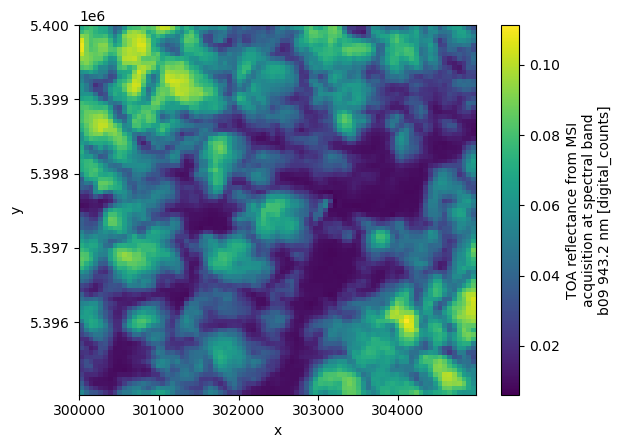

In [92]:
# We see , probably a boat.
# Todo, add plot for small_dt['conditions']['l1c_quicklook']['r10m']
# small_dt['conditions']['l1c_quicklook']['r10m'].hvplot.rgb(x='x',y='y', )

small_dt["measurements"]["reflectance"]["r60m"]["b09"].plot()

## Add Latitude/Longitude Coordinates

Using **pyproj** we transform UTM (x/y in meters) to geographic coordinates (lon/lat in degrees) and attach them as auxiliary coordinates. This enables subsequent binning onto a spherical grid.

### Annotate UTM with latitude and Longitude

In [93]:
def _add_latlon(ds: xr.Dataset, transformer: pyproj.Transformer) -> xr.Dataset:
    """Attach latitude/longitude coords + CF metadata to a Dataset with (x,y)."""
    if not {"x", "y"}.issubset(ds.dims):
        return ds

    xx, yy = np.meshgrid(ds["x"].values, ds["y"].values, indexing="xy")
    lon, lat = transformer.transform(xx, yy)

    ds = ds.assign_coords(
        longitude=(("y", "x"), lon),
        latitude=(("y", "x"), lat),
    )
    ds["latitude"].attrs.update(
        {
            "standard_name": "latitude",
            "long_name": "Latitude",
            "units": "degrees_north",
            "axis": "Y",
        }
    )
    ds["longitude"].attrs.update(
        {
            "standard_name": "longitude",
            "long_name": "Longitude",
            "units": "degrees_east",
            "axis": "X",
        }
    )

    # Make sure vars with (y,x) advertise the aux coords
    for var in ds.data_vars:
        if {"y", "x"}.issubset(ds[var].dims):
            existing = ds[var].attrs.get("coordinates", "").split()
            ds[var].attrs["coordinates"] = " ".join(
                sorted(set(existing) | {"latitude", "longitude"})
            )
    return ds


def add_latlon(
    path: str, ds: xr.Dataset, transformer: pyproj.Transformer
) -> xr.Dataset:
    """Wrapper for safe application on a node dataset."""
    if ds is None:
        print(path, "no dataset")
        return ds
    if not {"x", "y"}.issubset(ds.dims):
        print(path, "not both x,y")
        return ds
    return _add_latlon(ds, transformer)


def add_latlon_to_dt(dt: xr.DataTree) -> xr.DataTree:
    """Return a new DataTree with latitude/longitude coords added everywhere possible."""
    crs_code = dt.attrs["other_metadata"]["horizontal_CRS_code"]
    src_crs = pyproj.CRS.from_string(crs_code)
    transformer = pyproj.Transformer.from_crs(
        src_crs, pyproj.CRS.from_epsg(4326), always_xy=True
    )
    return xr.DataTree.from_dict(
        {
            path: add_latlon(path, node.ds, transformer)
            for path, node in dt.subtree_with_keys
        }
    )

In [65]:
%%time
latlon_dt = add_latlon_to_dt(small_dt)

. not both x,y
conditions not both x,y
measurements not both x,y
quality not both x,y
conditions/mask not both x,y
conditions/meteorology not both x,y
measurements/reflectance not both x,y
quality/l1c_quicklook not both x,y
quality/mask not both x,y
conditions/mask/detector_footprint not both x,y
conditions/mask/l1c_classification not both x,y
conditions/meteorology/cams not both x,y
conditions/meteorology/ecmwf not both x,y
CPU times: user 179 ms, sys: 2.23 ms, total: 181 ms
Wall time: 180 ms


<xarray.DataArray 'b02' (y: 500, x: 500)> Size: 2MB
dask.array<getitem, shape=(500, 500), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>
Coordinates:
  * y          (y) int64 4kB 5399995 5399985 5399975 ... 5395025 5395015 5395005
  * x          (x) int64 4kB 300005 300015 300025 ... 304975 304985 304995
    longitude  (y, x) float64 2MB -5.719 -5.719 -5.719 ... -5.649 -5.649 -5.649
    latitude   (y, x) float64 2MB 48.72 48.72 48.72 48.72 ... 48.68 48.68 48.68
Attributes: (13)

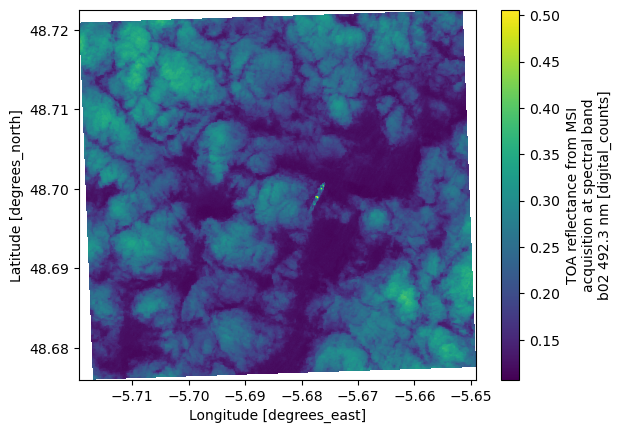

In [94]:
latlon_dt["measurements"]["reflectance"]["r10m"]["b02"].plot(
    x="longitude", y="latitude"
)
latlon_dt["measurements"]["reflectance"]["r10m"]["b02"]

In [95]:
import pyproj

crs_code = latlon_dt.attrs["other_metadata"]["horizontal_CRS_code"]

# Option 1: let pyproj parse the whole string
src_crs = pyproj.CRS.from_string(crs_code)

# Option 2: strip the prefix and give only the integer
# src_crs = pyproj.CRS.from_epsg(int(crs_code.split(":")[-1]))

transformer = pyproj.Transformer.from_crs(
    src_crs,
    pyproj.CRS.from_epsg(4326),
    always_xy=True
)

In [98]:
import healpy as hp
from foscat.Plot import lgnomproject
import matplotlib.pyplot as plt

ds=latlon_dt["measurements"]["reflectance"]["r10m"]["b02"]

level=20
lon = ds["longitude"].values.ravel()
lat = ds["latitude"].values.ravel()

# Convert lon/lat to HEALPix spherical angles
theta = np.deg2rad(90.0 - lat)
phi   = np.deg2rad(lon)

# Compute interpolation weights and indices for projecting from HEALPix to the UTM grid
I, W = hp.get_interp_weights(2**level, theta, phi, nest=True)

# compute square of the distance
vecr = hp.ang2vec(theta, phi)
xc,yc,zc = hp.pix2vec(2**level,I,nest=True)
distance2=(4**level)*((vecr[None,:,0]-xc)**2+(vecr[None,:,1]-yc)**2+(vecr[None,:,2]-zc)**2)

#compute weights
w=np.exp(-distance2)
w/=np.sum(w,0)[None,:]

# Identify the unique HEALPix cells that will contribute to u
cell_ids, indices = np.unique(I, return_inverse=True)

#compute distance 
imh=np.bincount(indices.flatten(),w.flatten())
im=np.bincount(indices.flatten(),w.flatten()*np.tile(ds.values.flatten(),4))
w.shape,ds.shape

((4, 250000), (500, 500))

<Axes: xlabel='Longitude (deg)', ylabel='Latitude (deg)'>

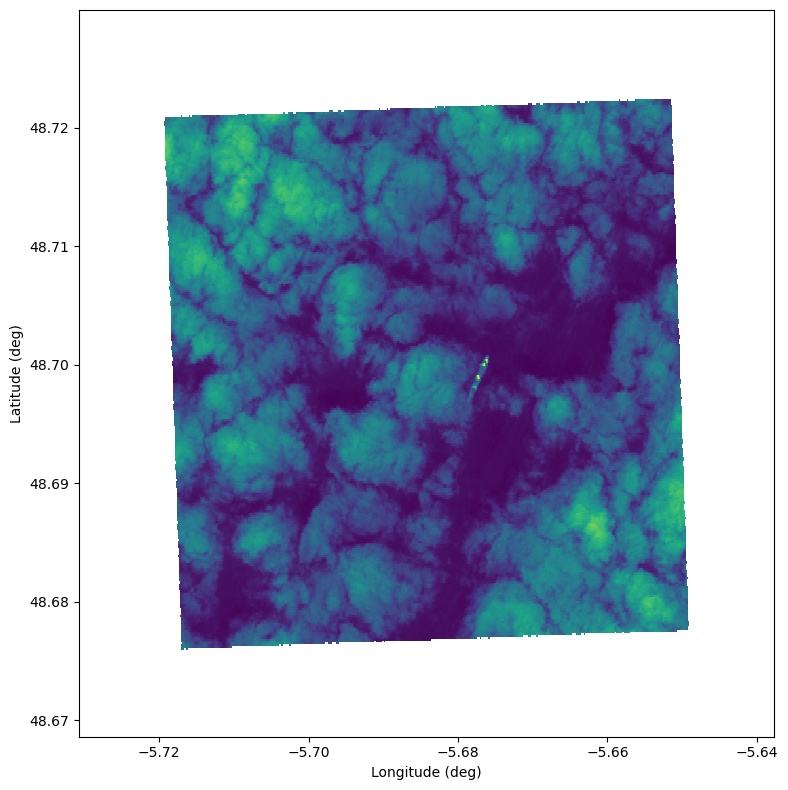

In [99]:

plt.figure(figsize=(8,8))
lgnomproject(cell_ids,im/imh,2**level,hold=False,xsize=1024)

## 5. **Inverse Problem Solution**  

## Conversion to HEALPix

We check dimensions and metadata (e.g., `cell_ids`, level, indexing scheme) and ensure variables were preserved.

In [100]:
import pathlib
import healpy as hp
#from healpix_geo.nested import lonlat_to_healpix


# --- level selection (coarsest grid not finer than dx) ---
EARTH_RADIUS_M = 6_371_000.0  # radius used in healpix-geo levels table


def _healpix_edge_length_m(level: int, radius_m: float = EARTH_RADIUS_M) -> float:
    # edge = R * sqrt(pi/3) / 2**level  (matches healpix-geo "levels" page)
    return radius_m * np.sqrt(np.pi / 3.0) / (2**level)


def _infer_dx_from_x(ds: xr.Dataset) -> float:
    x = np.asarray(ds["x"].values)
    dx = float(np.nanmedian(np.abs(np.diff(x))))
    if not np.isfinite(dx) or dx <= 0:
        raise ValueError("Could not infer a positive spacing from ds['x'].")
    return dx


def _choose_healpix_level_from_dx(
    ds: xr.Dataset, min_level: int = 0, max_level: int = 29
) -> int:
    dx = _infer_dx_from_x(ds)
    base = EARTH_RADIUS_M * np.sqrt(np.pi / 3.0)
    level = int(np.floor(np.log2(base / dx))) +1 # edge(level) >= dx
    return int(np.clip(level, min_level, max_level))


# --- single-dataset transform -> grouped by unique HEALPix cell_ids ---
def _to_healpix_cells_grouped_mean(
    ds: xr.Dataset, 
    level: int | None = None, 
    ellipsoid: str = "WGS84",
    mask_info: bool = False
) -> xr.Dataset:
    """
    Returns a dataset with dims (angle, cell_ids), where 'cell_ids' is a
    dimension/coordinate containing unique HEALPix ids (NESTED).
    Values are averaged over all source samples that mapped to the same cell.
    """
    if not {"y", "x"}.issubset(ds.dims):
        raise ValueError("Dataset must have 'y' and 'x' dimensions.")
    if not {"latitude", "longitude"}.issubset(ds.coords):
        raise ValueError(
            "Dataset must have 'latitude' and 'longitude' coords (degrees)."
        )

    if level is None:
        level = _choose_healpix_level_from_dx(ds)

    # 1) hash each (lon,lat) to HEALPix nested cell id
    lon = ds["longitude"].values.ravel()
    lat = ds["latitude"].values.ravel()

    # Convert lon/lat to HEALPix spherical angles
    theta = np.deg2rad(90.0 - lat)
    phi   = np.deg2rad(lon)

    nside = 2**level

    if mask_info:
        # Compute interpolation weights and indices for projecting from HEALPix to the UTM grid
        # it is not to use it in the mask computation, but to have the same cell_ids than the other data
        I, W = hp.get_interp_weights(2**level, theta, phi, nest=True)
        
        # Identify the unique HEALPix cells that will contribute to u
        cell_ids, indices = np.unique(I, return_inverse=True)
        
        l_cell_ids = hp.ang2pix(nside,theta,phi,nest=True)

        # Identify the unique HEALPix cells that will contribute to u
        indices = np.searchsorted(cell_ids,l_cell_ids)
        
        o_cell_ids = cell_ids.astype("int64")

        # now I need to merge flags
        N = o_cell_ids.size  # number of HEALPix cells

        cell_dim = "cells"        # name of the new dimension
        cid_name = "cell_ids"    # name of the coordinate storing HEALPix IDs
        
        # 1) Build the 1D Dataset
        data_vars = {}
        for v in ds.data_vars:   
            patch = ds[v].values
            # run your solver to compute values instead of zeros
            vals=np.zeros([N],dtype='uint8')

            for k in range(8):
                vals+=(np.bincount(indices.flatten(),(patch.flatten()>>k)&1,minlength=N)>0).astype('uint8')*2**k
                
            # Each variable must have shape (cell,)
            data_vars[v] = ((cell_dim,), vals)
            
            # 2) Create the Dataset with the HEALPix cell_ids as a coordinate
            out = xr.Dataset(
                data_vars=data_vars,
                coords={cid_name: ((cell_dim,), o_cell_ids)}
            ) 
        
        # 4) Add metadata to the cell_ids coordinate
        out[cid_name].attrs.update({"standard_name": "healpix", "units": "1"})
        
        # 3) Use the cell_ids coordinate as the index of the 'cell' dimension
        out = out.set_index({cell_dim: cid_name})
        
        # 5) Copy global attributes from the original dataset
        out.attrs = dict(ds.attrs)
        # 6) Copy variable-specific attributes from the original dataset
        for v in ds.data_vars:
            out[v].attrs = dict(ds[v].attrs)
        
    elif lon.shape[0]<100: # do not convert with PSF deconv small data
        o_cell_ids = hp.ang2pix(nside,theta,phi,nest=True)
            
        #cell_ids = lonlat_to_healpix(lon, lat, level, ellipsoid=ellipsoid)
        # 2) stack (y,x) -> cells
        out = ds.stack(cells=("y", "x"))
        
        # 3) attach cell_ids coord on 'cells'
        out = out.assign_coords(cell_ids=("cells", o_cell_ids.astype("int64")))
        out["cell_ids"].attrs.update({"standard_name": "healpix", "units": "1"})
        cell_ids_attrs = dict(out["cell_ids"].attrs)  # keep for after groupby
    
        # 4) drop redundant coords/vars
        #    drop_these = [n for n in ("x", "y", "latitude", "longitude") if n in out.variables]
        #    out = out.drop_vars(drop_these)
    
        # 5) group by cell_ids and average
        # **note** This is a very simplified test conversion,
        # later this should be updated spline other interpolation methods.
        out = out.groupby("cell_ids").mean().rename_dims(cell_ids="cells")
        # 6) restore attrs on the new dimension coordinate
        if "cell_ids" in out.coords:
            out["cell_ids"].attrs.update(cell_ids_attrs)
    else:
        # Compute interpolation weights and indices for projecting from HEALPix to the UTM grid
        I, W = hp.get_interp_weights(2**level, theta, phi, nest=True)
        
        # Identify the unique HEALPix cells that will contribute to u
        cell_ids, indices = np.unique(I, return_inverse=True)

        # compute square of the distance
        vecr = hp.ang2vec(theta, phi)
        xc,yc,zc = hp.pix2vec(2**level,I,nest=True)
        distance2=(4**level)*((vecr[None,:,0]-xc)**2+(vecr[None,:,1]-yc)**2+(vecr[None,:,2]-zc)**2)

        #compute weights
        w=np.exp(-distance2)
        w/=np.sum(w,0)[None,:]

    
        o_cell_ids = cell_ids.astype("int64")
        
        N = o_cell_ids.size  # number of HEALPix cells


        cell_dim = "cells"        # name of the new dimension
        cid_name = "cell_ids"    # name of the coordinate storing HEALPix IDs

        # compute hit count map
        hit_var=np.bincount(indices.flatten(),w.flatten())

        # 1) Build the 1D Dataset
        test_rgb=False

        data_vars={}
        data_vars['hits'] = ((cell_dim,), hit_var)
        for v in ds.data_vars:
            patch = ds[v].values
            if len(patch.shape)>2: # RGB
                test_rgb=True
                
                vals=[]
                for k in range(3):
                    vals.append(np.bincount(indices.flatten(),w.flatten()*np.tile(patch[k].flatten().astype('float'),4))/hit_var)
                vals=np.vstack(np.clip(vals,0,255)).astype('uint8')  
                data_vars[v] = (('band',cell_dim,), vals)
            else:
                # run your solver to compute values instead of zeros
                vals=np.bincount(indices.flatten(),w.flatten()*np.tile(patch.flatten().astype('float'),4))/hit_var
                
                # Each variable must have shape (cell,)
                data_vars[v] = ((cell_dim,), vals)
        if test_rgb:
            # 2) Create the Dataset with the HEALPix cell_ids as a coordinate
            out = xr.Dataset(
                data_vars=data_vars,
                coords={'band':np.arange(3),cid_name: ((cell_dim,), o_cell_ids)}
            )
        else:
            # 2) Create the Dataset with the HEALPix cell_ids as a coordinate
            out = xr.Dataset(
                data_vars=data_vars,
                coords={cid_name: ((cell_dim,), o_cell_ids)}
            ) 
        
        # 4) Add metadata to the cell_ids coordinate
        out[cid_name].attrs.update({"standard_name": "healpix", "units": "1"})
        
        # 3) Use the cell_ids coordinate as the index of the 'cell' dimension
        out = out.set_index({cell_dim: cid_name})
        
        # 5) Copy global attributes from the original dataset
        out.attrs = dict(ds.attrs)
        # 6) Copy variable-specific attributes from the original dataset
        for v in ds.data_vars:
            out[v].attrs = dict(ds[v].attrs)

    # 7) keep order stable for variables like (angle, cell_ids)
    #   for v in out.data_vars:
    #       if ("angle" in out[v].dims) and ("cell_ids" in out[v].dims):
    #           out[v] = out[v].transpose("angle", "cell_ids", ...)

    return out


def _update_group_metadata(
    ds: xr.Dataset,
    level: int,
    ellipsoid: str = "WGS84",
    grid_mapping_var_name: str = "crs",
) -> xr.Dataset:
    """Update metadata of a single group."""

    if "cells" not in ds.dims:
        return ds

    ds_healpix = ds.copy()

    # create healpix grid mapping variable
    ds_healpix.coords[grid_mapping_var_name] = (
        (),
        0,
        {
            "grid_mapping_name": "healpix",
            "indexing_scheme": "nested",
            "refinement_ratio": 4,
            "refinement_level": level,
            "reference_body": ellipsoid,
        },
    )

    # update variable attributes
    # dimensions, coordinates and grid_mapping attributes
    # clean-up non-healpix variable attributes
    for var_name, var in ds_healpix.variables.items():
        if "cells" in var.dims:
            attrs = var.attrs.copy()
            eopf_attrs = attrs.get("_eopf_attrs", None)
            if eopf_attrs is not None:
                eopf_attrs["dimensions"] = ["cells"]
                eopf_attrs["coordinates"] = ["cell_ids"]
            for name in var.attrs:
                if "proj:" in name:
                    del attrs[name]
            if "coordinates" in var.attrs:
                attrs["coordinates"] = "cell_ids"
            if var_name != "cell_ids":
                attrs["grid_mapping"] = grid_mapping_var_name
            var.attrs = attrs

    return ds_healpix


# --- HEALPix group converter ---
def _add_healpix_to_group(path: str, ds: xr.Dataset) -> tuple[xr.Dataset, int | None]:
    if ds is None:
        print(path, "no dataset — keeping empty group")
        return xr.Dataset()

    has_xy = {"x", "y"}.issubset(ds.dims)
    has_ll = {"latitude", "longitude"}.issubset(ds.coords)

    if has_xy and not has_ll:
        # stop the whole operation as requested
        raise RuntimeError(
            f"{path}: has x/y but missing latitude/longitude — aborting."
        )

    if has_ll and has_xy:
        level = _choose_healpix_level_from_dx(ds)
        print(
            f"{path}: chosen level {level} (edge≈{_healpix_edge_length_m(level):.4f} m)"
        )
        ds_healpix = _to_healpix_cells_grouped_mean(ds, level=level, ellipsoid="WGS84",mask_info='mask' in path)
        ds_healpix = _update_group_metadata(ds_healpix, level=level, ellipsoid="WGS84")
        return ds_healpix, level

    # no lat/lon -> do nothing
    print(path, "no latitude/longitude — skipping")
    return ds, None


def _update_stac_discovery(attrs: dict):
    """Update product level STAC."""

    # TODO: update "bbox" and "geometry" attributes to
    # so it is consistent with HEALPix cell geometries

    props = attrs["properties"].copy()

    # remove irrelevant properties for HEALPix
    for k in attrs["properties"]:
        if "proj:" in k:
            del props[k]

    # TODO: add STAC discovery "grid:code" property
    # "grid:code" value is formatted like "HEALPIX-I{indexing_scheme}-L{level}-{cell_id}"
    # use a placeholder cell id value for now (to be defined)
    #props["grid:code"] = "HEALPIX-Inested-L10-1234"
    #attrs["stac_extensions"].append(
    #    "https://stac-extensions.github.io/grid/v1.1.0/schema.json"
    #)

    # TODO: update "bbox" and "geometry" attribute values.

    attrs["properties"] = props


# --- public function: apply over the whole DataTree ---
def add_healpix_to_dt(dt: xr.DataTree) -> xr.DataTree:
    """Transform nodes to HEALPix (grouped mean per cell) where possible; preserve others."""

    # HEALPix multiscale attribute convention
    # (inspired from https://github.com/zarr-developers/geozarr-spec/issues/83#issuecomment-3292459330)
    multiscales_attr = {
        "name": "healpix",
        "configuration": {"refinement_ratio": 4},
    }
    multiscale_paths = set()

    # process datatree group by group
    updated_groups = {}
    for path, group in dt.subtree_with_keys:
        path = pathlib.Path(path)
        ds_healpix, level = _add_healpix_to_group(str(path), group.ds)

        # detect multiscale and rename group according to
        # HEALPix refinement level
        if level is not None:
            path = path.parent / str(level)
            multiscale_paths.add(str(path.parent))

        updated_groups[str(path)] = ds_healpix

    dt_healpix = xr.DataTree.from_dict(updated_groups, name=getattr(dt, "name", None))

    # add multiscale metadata
    for path, group in dt_healpix.subtree_with_keys:
        if path in multiscale_paths:
            group.attrs["multiscales"] = multiscales_attr

    # update product level metadata
    _update_stac_discovery(dt_healpix.attrs["stac_discovery"])

    return dt_healpix


# compute ONE patch

In [101]:
def get_sub_pieces(dt,x_beg,x_end,y_beg,y_end):
    small_dt = dt.sel(
        x=slice(x_beg,x_end),y=slice(y_beg,y_end),
    )
    latlon_dt = add_latlon_to_dt(small_dt)

    # Convert the whole tree
    return add_healpix_to_dt(latlon_dt)

# Utilities for data tree merging

In [102]:
import numpy as np
import xarray as xr

def has_healpix_index(ds: xr.Dataset, cell_dim="cells") -> bool:
    return (cell_dim in ds.dims) or ("cell_ids" in ds.dims) or ("cell_ids" in ds.coords)
    
def ensure_cell_dim_preserve_ids(ds: xr.Dataset, *, cell_dim="cells") -> xr.Dataset:
    """
    Ensure the dataset has a single HEALPix dimension `cell_dim` whose
    *dimension coordinate values are the true HEALPix IDs* (int64).
    Rules:
      - If dim is already `cell_dim` and a coord `cell_ids` exists with same length,
        use its values for the dim coordinate (then drop the extra coord).
      - If the dim is named 'cell_ids', rename dim AND coordinate to `cell_dim`,
        keeping values (the true IDs).
      - If only a non-dim coord 'cell_ids' exists, promote it as the dim coordinate.
    """
    ds2 = ds

    # Case 1: target dim already present
    if cell_dim in ds2.dims:
        # If there is a coord 'cell_ids' aligned on this dim and it differs, use it.
        if "cell_ids" in ds2.coords and ds2["cell_ids"].dims == (cell_dim,):
            cid = xr.DataArray(ds2["cell_ids"]).astype("int64")
            if cid.sizes[cell_dim] == ds2.sizes[cell_dim]:
                # Replace the dimension coordinate values by the true IDs
                ds2 = ds2.assign_coords({cell_dim: cid})
                # Remove the extra coord to avoid future alignment conflicts
                ds2 = ds2.drop_vars("cell_ids")
        # Ensure the dim coord exists and is int64
        if (cell_dim not in ds2.coords) or (ds2[cell_dim].dims != (cell_dim,)):
            ds2 = ds2.assign_coords({cell_dim: (cell_dim, ds2[cell_dim].values)})
        ds2 = ds2.assign_coords({cell_dim: ds2[cell_dim].astype("int64")})
        ds2[cell_dim].attrs.update({"standard_name": "healpix", "units": "1"})
        return ds2

    # Case 2: the dimension is named 'cell_ids' -> rename dim *and* coord to `cell_dim`
    if "cell_ids" in ds2.dims:
        ren_dims = {"cell_ids": cell_dim}
        ren_vars = {"cell_ids": cell_dim} if "cell_ids" in ds2.coords else {}
        ds2 = ds2.rename_dims(ren_dims).rename_vars(ren_vars)
        # Ensure dim coord exists & int64
        if (cell_dim not in ds2.coords) or (ds2[cell_dim].dims != (cell_dim,)):
            ds2 = ds2.assign_coords({cell_dim: (cell_dim, ds2[cell_dim].values)})
        ds2 = ds2.assign_coords({cell_dim: ds2[cell_dim].astype("int64")})
        ds2[cell_dim].attrs.update({"standard_name": "healpix", "units": "1"})
        return ds2

    # Case 3: only a non-dim coord 'cell_ids' exists -> promote it as dim coord
    if "cell_ids" in ds2.coords:
        cid = np.asarray(ds2["cell_ids"].values).ravel().astype("int64")
        ds2 = xr.Dataset(
            data_vars={k: v for k, v in ds2.data_vars.items()},
            coords={cell_dim: (cell_dim, cid),
                    **{k: v for k, v in ds2.coords.items() if k != "cell_ids"}}
        )
        ds2[cell_dim].attrs.update({"standard_name": "healpix", "units": "1"})
        return ds2

    raise ValueError("No HEALPix index found: need 'cells' dim, 'cell_ids' dim, or 'cell_ids' coord.")

def merge_two_healpix_union_mean_or(ds1: xr.Dataset, ds2: xr.Dataset, *, cell_dim="cells") -> xr.Dataset:
    ds1 = ensure_cell_dim_preserve_ids(ds1, cell_dim=cell_dim)
    ds2 = ensure_cell_dim_preserve_ids(ds2, cell_dim=cell_dim)

    all_cells = np.union1d(ds1[cell_dim].values, ds2[cell_dim].values)

    def _reindex(ds):
        ds_r = ds.reindex({cell_dim: all_cells}, fill_value=None)
        fill_vals = {name: (0 if ds[name].dtype == np.uint8 else np.nan) for name in ds_r.data_vars}
        return ds_r.fillna(fill_vals)

    ds1r, ds2r = _reindex(ds1), _reindex(ds2)

    merged_vars = {}
    for name in ds1r.data_vars:
        a, b = xr.align(ds1r[name], ds2r[name], join="outer")
        if a.dtype == np.uint8:
            merged = xr.apply_ufunc(np.bitwise_or, a.astype(np.uint8), b.astype(np.uint8),
                                    dask="parallelized", output_dtypes=[np.uint8])
        else:
            merged = xr.concat([a, b], dim="_patch").mean("_patch", skipna=True)
        merged_vars[name] = merged

    out = xr.Dataset(merged_vars, coords={cell_dim: (cell_dim, all_cells.astype("int64"))})
    out.attrs = dict(ds1.attrs)
    for v in out.data_vars:
        if v in ds1:
            out[v].attrs = dict(ds1[v].attrs)
    out[cell_dim].attrs.update({"standard_name": "healpix", "units": "1"})
    return out


# Merge a list of Datasets (one group) by mean / bitwise-OR

In [103]:
from pathlib import Path

def _groups_from_patch(patch, only_healpix: bool, cell_dim="cells") -> dict[str, xr.Dataset]:
    """Supporte xr.DataTree, dict[str, xr.Dataset], xr.Dataset."""
    out = {}
    if hasattr(patch, "subtree_with_keys"):               # xr.DataTree-like
        for path, node in patch.subtree_with_keys:
            ds = getattr(node, "ds", None)
            if isinstance(ds, xr.Dataset) and len(ds.data_vars) > 0:
                if not only_healpix or has_healpix_index(ds, cell_dim=cell_dim):
                    out[str(path)] = ds
        return out
    if isinstance(patch, dict):                           # dict[path] = Dataset
        for path, ds in patch.items():
            if isinstance(ds, xr.Dataset) and len(ds.data_vars) > 0:
                if not only_healpix or has_healpix_index(ds, cell_dim=cell_dim):
                    out[str(path)] = ds
        return out
    if isinstance(patch, xr.Dataset):                     # single dataset at root
        if len(patch.data_vars) > 0 and (not only_healpix or has_healpix_index(patch, cell_dim=cell_dim)):
            out["/"] = patch
        return out
    raise TypeError("Unsupported patch type.")

def merge_patches_groupwise_into_initial_dt(
    initial_dt: xr.DataTree,
    patches: list,                     # éléments: xr.DataTree | dict[str, xr.Dataset] | xr.Dataset
    *,
    cell_dim="cells",
    only_healpix=True,
    keep_non_healpix: str | None = "first",
    multiscales_attr: dict | None = None,
) -> xr.DataTree:
    """
    Fusionne tous les `patches` dans `initial_dt` et retourne un xr.DataTree.
    - HEALPix: union + mean/OR
    - non-HEALPix: gardé tel quel (ou ignoré si keep_non_healpix=None)
    - Attributs: priorité à ceux de `initial_dt`
    - Optionnel: ajoute un attr 'multiscales' sur des chemins parent (si tu veux)
    """
    # 1) collecter les groupes de l'initial et des patches
    init_map = _groups_from_patch(initial_dt, only_healpix=False, cell_dim=cell_dim)
    patch_maps = [_groups_from_patch(p, only_healpix=only_healpix, cell_dim=cell_dim) for p in patches]

    paths = set(init_map.keys())
    for m in patch_maps:
        paths |= set(m.keys())

    updated_groups: dict[str, xr.Dataset] = {}
    multiscale_paths = set()

    # 2) fusion par chemin
    for path in sorted(paths):
        base = init_map.get(path)
        others = [m[path] for m in patch_maps if path in m]

        # déterminer si groupe HEALPix
        probe = base if base is not None else (others[0] if others else None)
        if probe is None:
            continue
        is_hp = has_healpix_index(probe, cell_dim=cell_dim)

        if is_hp:
            acc = base if base is not None else others[0]
            start_idx = 0 if base is None else 0
            for ds in (others if base is not None else others[1:]):
                acc = merge_two_healpix_union_mean_or(acc, ds, cell_dim=cell_dim)

            # attrs depuis l'initial si dispo
            if base is not None:
                acc.attrs = dict(base.attrs)
                for v in acc.data_vars:
                    if v in base:
                        acc[v].attrs = dict(base[v].attrs)

            updated_groups[path] = acc

            # (optionnel) log multiscale si ton code renomme par niveau
            # à adapter si tu veux dériver 'level' ici
            # if some_level is not None:
            #     parent = str(Path(path).parent)
            #     multiscale_paths.add(parent)

        else:
            # non-HEALPix
            if base is not None:
                updated_groups[path] = base
            elif keep_non_healpix == "first" and others:
                updated_groups[path] = others[0]
            # sinon: ignorer

    # 3) reconstruire un xr.DataTree
    name = getattr(initial_dt, "name", None)
    dt_out = xr.DataTree.from_dict(updated_groups, name=name)

    # 4) recopier les attrs globaux de l'initial
    try:
        dt_out.attrs.update(dict(initial_dt.attrs))
    except Exception:
        pass

    # 5) (optionnel) ajouter des métadonnées multiscales sur certains chemins
    if multiscales_attr and multiscale_paths:
        for path, node in dt_out.subtree_with_keys:
            if path in multiscale_paths:
                node.attrs["multiscales"] = multiscales_attr

    return dt_out

In [104]:
%%time

# pre-loading data may speed-up the conversion depending on network conditions
#latlon_dt.load()
# Convert the whole tree
all_dt = None
for k in range(3): #dt["conditions"]["geometry"]["sun_angles"].x.shape[0]-1):
    for l in range(3): #dt["conditions"]["geometry"]["sun_angles"].y.shape[0]-1):
        print('======================================')
        print(f' Patch {k,l} start ...')
        local_dt = get_sub_pieces(dt,
                                  dt["conditions"]["geometry"]["sun_angles"].x[k],
                                  dt["conditions"]["geometry"]["sun_angles"].x[k+1],
                                  dt["conditions"]["geometry"]["sun_angles"].y[l],
                                  dt["conditions"]["geometry"]["sun_angles"].y[l+1])

        if all_dt is None:
            all_dt=local_dt
        else:
            all_dt= merge_patches_groupwise_into_initial_dt(
                initial_dt=all_dt,            # ton xr.DataTree de base
                patches=[local_dt],            # un ou plusieurs patches (xr.DataTree, dict ou Dataset)
                cell_dim="cells",
                only_healpix=False,
                keep_non_healpix="first",
                multiscales_attr={"name": "healpix", "configuration": {"refinement_ratio": 4}},  
            )
        print(f' Patch {k,l} computed')
        print('======================================')
        

all_dt

 Patch (0, 0) start ...
. not both x,y
conditions not both x,y
measurements not both x,y
quality not both x,y
conditions/mask not both x,y
conditions/meteorology not both x,y
measurements/reflectance not both x,y
quality/l1c_quicklook not both x,y
quality/mask not both x,y
conditions/mask/detector_footprint not both x,y
conditions/mask/l1c_classification not both x,y
conditions/meteorology/cams not both x,y
conditions/meteorology/ecmwf not both x,y
. no latitude/longitude — skipping
conditions no latitude/longitude — skipping
measurements no latitude/longitude — skipping
quality no latitude/longitude — skipping
conditions/geometry: chosen level 11 (edge≈3183.4055 m)
conditions/mask no latitude/longitude — skipping
conditions/meteorology no latitude/longitude — skipping
measurements/reflectance no latitude/longitude — skipping
quality/l1c_quicklook no latitude/longitude — skipping
quality/mask no latitude/longitude — skipping
conditions/mask/detector_footprint no latitude/longitude — sk

<xarray.DataTree>
Group: /
│   Attributes: (3)
├── Group: /conditions
│   ├── Group: /conditions/11
│   │       Dimensions:                        (angle: 2, cells: 16, band: 13, detector: 7)
│   │       Coordinates:
│   │         * angle                          (angle) <U7 56B 'zenith' 'azimuth'
│   │         * cells                          (cells) int64 128B 14117805 ... 14139688
│   │         * band                           (band) <U3 156B 'b01' 'b02' ... 'b11' 'b12'
│   │         * detector                       (detector) int64 56B 3 4 5 6 7 8 9
│   │           crs                            int64 8B 0
│   │       Data variables:
│   │           mean_sun_angles                (cells, angle) float64 256B dask.array<chunksize=(1, 2), meta=np.ndarray>
│   │           mean_viewing_incidence_angles  (cells, band, angle) float64 3kB dask.array<chunksize=(1, 13, 2), meta=np.ndarray>
│   │           sun_angles                     (cells, angle) float64 256B dask.array<chunksize=(1, 2), meta=np.ndarray>
│   │           viewing_incidence_angles       (cells, band, detector, angle) float64 23kB dask.array<chunksize=(1, 7, 4, 2), meta=np.ndarray>
│   ├── Group: /conditions/meteorology
│   │   ├── Group: /conditions/meteorology/cams
│   │   │       Dimensions:        (latitude: 9, longitude: 9)
│   │   │       Coordinates:
│   │   │         * latitude       (latitude) float64 72B 48.72 48.6 48.48 ... 48.0 47.88 47.76
│   │   │         * longitude      (longitude) float64 72B -5.719 -5.53 -5.34 ... -4.393 -4.204
│   │   │           isobaricInhPa  float64 8B ...
│   │   │           number         int64 8B ...
│   │   │           step           int64 8B ...
│   │   │           surface        float64 8B ...
│   │   │           time           datetime64[ns] 8B ...
│   │   │           valid_time     datetime64[ns] 8B ...
│   │   │       Data variables:
│   │   │           aod1240        (latitude, longitude) float32 324B dask.array<chunksize=(9, 9), meta=np.ndarray>
│   │   │           aod469         (latitude, longitude) float32 324B dask.array<chunksize=(9, 9), meta=np.ndarray>
│   │   │           aod550         (latitude, longitude) float32 324B dask.array<chunksize=(9, 9), meta=np.ndarray>
│   │   │           aod670         (latitude, longitude) float32 324B dask.array<chunksize=(9, 9), meta=np.ndarray>
│   │   │           aod865         (latitude, longitude) float32 324B dask.array<chunksize=(9, 9), meta=np.ndarray>
│   │   │           bcaod550       (latitude, longitude) float32 324B dask.array<chunksize=(9, 9), meta=np.ndarray>
│   │   │           duaod550       (latitude, longitude) float32 324B dask.array<chunksize=(9, 9), meta=np.ndarray>
│   │   │           omaod550       (latitude, longitude) float32 324B dask.array<chunksize=(9, 9), meta=np.ndarray>
│   │   │           ssaod550       (latitude, longitude) float32 324B dask.array<chunksize=(9, 9), meta=np.ndarray>
│   │   │           suaod550       (latitude, longitude) float32 324B dask.array<chunksize=(9, 9), meta=np.ndarray>
│   │   │           z              (latitude, longitude) float32 324B dask.array<chunksize=(9, 9), meta=np.ndarray>
│   │   │       Attributes: (7)
│   │   └── Group: /conditions/meteorology/ecmwf
│   │           Dimensions:        (latitude: 9, longitude: 9)
│   │           Coordinates:
│   │             * latitude       (latitude) float64 72B 48.72 48.6 48.48 ... 48.0 47.88 47.76
│   │             * longitude      (longitude) float64 72B -5.719 -5.53 -5.34 ... -4.393 -4.204
│   │               isobaricInhPa  float64 8B ...
│   │               number         int64 8B ...
│   │               step           int64 8B ...
│   │               surface        float64 8B ...
│   │               time           datetime64[ns] 8B ...
│   │               valid_time     datetime64[ns] 8B ...
│   │           Data variables:
│   │               msl            (latitude, longitude) float32 324B dask.array<chunksize=(9, 9), meta=np.ndarray>
│   │               r      

## Save & Export

We persist the HEALPix‑indexed data as **Zarr**

<Axes: title={'center': 'quality/l1c_quicklook/20/tci'}, xlabel='Longitude (deg)', ylabel='Latitude (deg)'>

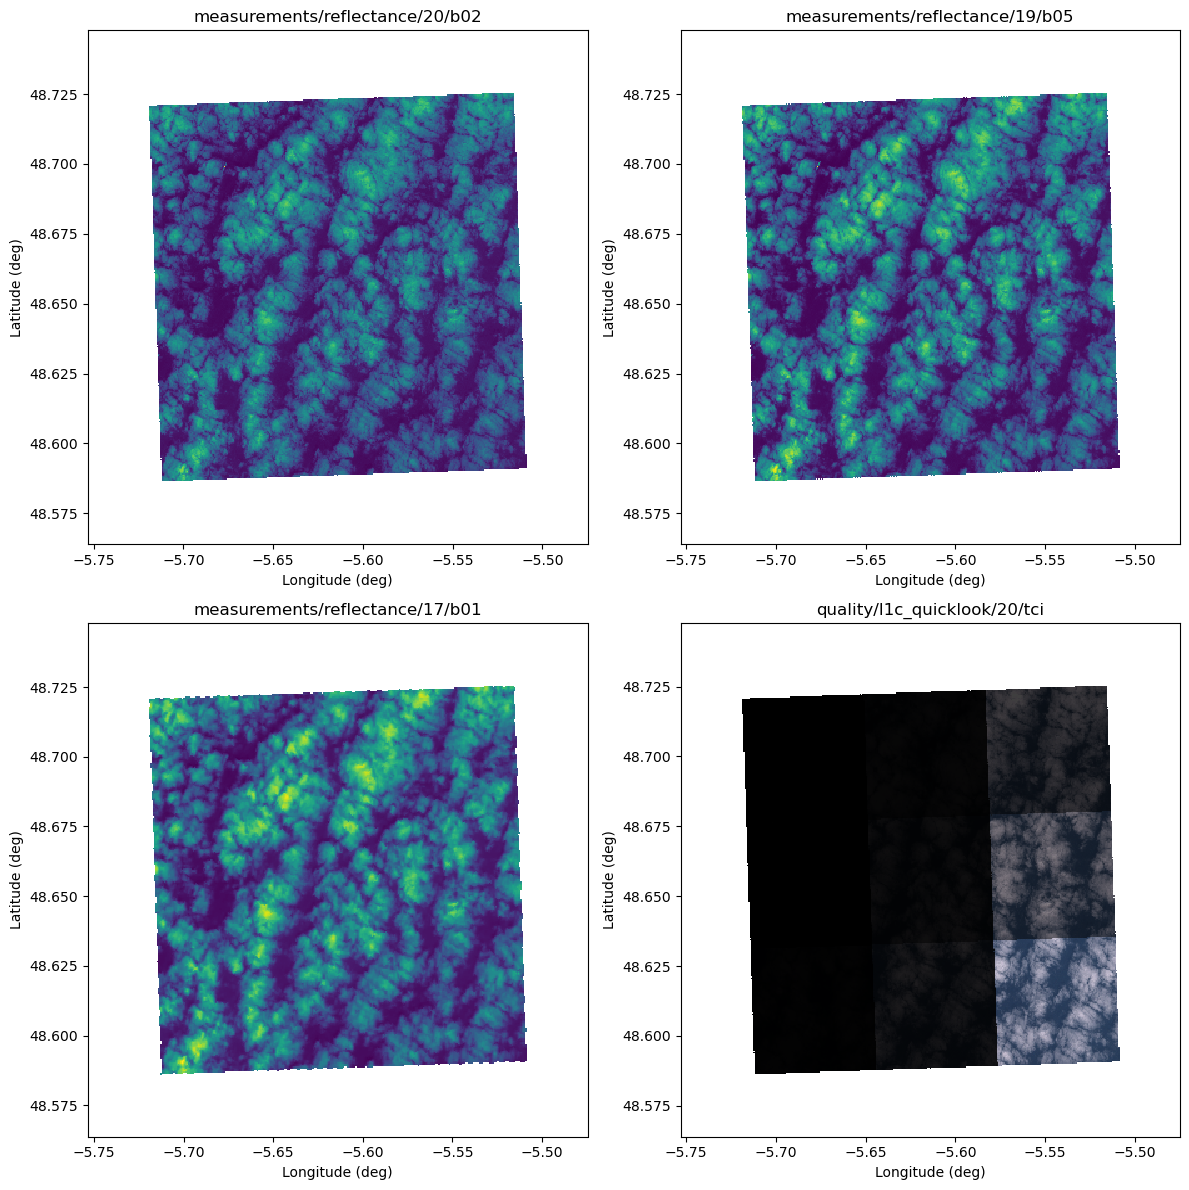

In [89]:
from foscat.Plot import lgnomproject
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
lgnomproject(all_dt['measurements']['reflectance']['20'].cells,
             all_dt['measurements']['reflectance']['20']['b02'].values,2**20,hold=False,sub=(2,2,1),
            title='measurements/reflectance/20/b02')
lgnomproject(all_dt['measurements']['reflectance']['19'].cells,
             all_dt['measurements']['reflectance']['19']['b05'].values,2**19,hold=False,sub=(2,2,2),
            title='measurements/reflectance/19/b05')
lgnomproject(all_dt['measurements']['reflectance']['17'].cells,
             all_dt['measurements']['reflectance']['17']['b01'].values,2**17,hold=False,sub=(2,2,3),
            title='measurements/reflectance/17/b01')
lgnomproject(all_dt['quality']['l1c_quicklook']['20'].cells,
             all_dt['quality']['l1c_quicklook']['20']['tci'].values.T/256.0,2**20,hold=False,sub=(2,2,4),
            title='quality/l1c_quicklook/20/tci')

In [ ]:
# todo rechunk here (may be re-use rechunk function justus will propose for climate dt for optimal chunking of healpix?)

all_dt.to_zarr(collection + "_healpix.zarr", mode="w")

## Appendix / References

- EOPF Sample Notebooks (Sentinel‑2): examples of structure and style for cloud‑native EO workflows.
- HEALPix: Górski et al., 2005. *ApJ* 622, 759–771.
- PyProj/PROJ: Coordinate transforms between projected and geographic systems.
- Xarray DataTree: Hierarchical datasets for multi‑group EO products.
